# Utilisation de Explauto pour faire bouger des objets

Nous allons reprendre le torse de Poppy tel que l'on pouvait l'utiliser lors du TD 1.

L'objectif de ce TD est d'utiliser Explauto pour générer des données d'apprentissage, lesquelles seront utilisées par Poppy pour faire bouger un objet (on travaillera sur un cube).

# Instanciation du poppy et du cube

On se définit un jeu de fonctions permettant:

  * La connexion à vrep,
  * L'instanciation de l'environnement, de Poppy (torse) et des modèles d'intérêt/sensorimoteur vierges
  * Le chargement des modèles d'intérêt et sensorimoteur depuis un fichier 
  * La création de l'expérience

La première fonction s'exécute que l'on souhaite réaliser l'apprentissage ou non. Si l'on souhaite charger des données d'apprentissage, la troisième fonction est utile, sinon il faut créer des modèles vides, et exécuter l'expérience d'apprentissage.

In [1]:
from poppy.creatures import PoppyTorso
from explauto.environment.poppy import PoppyEnvironment

from explauto import InterestModel, SensorimotorModel
from explauto import Agent, Experiment
import numpy

import pickle

%matplotlib inline
import matplotlib.pyplot as libplot
from mpl_toolkits.mplot3d import Axes3D

import pypot

def resetPoppy():
    global poppy
    pypot.vrep.close_all_connections()
    poppy = PoppyTorso(simulator='vrep', scene='/home/corentin/ENS/L3/TDs/INVITE/n/poppy_avec_cube.ttt')
    
def resetEnv(tracked_obj, m_mins, m_maxs, s_mins, s_maxs):
    global env, sm_model, im_model, xp, agent, poppy, X, Y, Z
    # The move duration (in s)
    move_duration = 2.0
    # On pilotera le bras gauche de poppy, les mouvements dureront deux secondes
    motors = poppy.l_arm
    # let's define the environment
    env = PoppyEnvironment(poppy, 
                       motors, move_duration,
                       poppy, tracked_obj,
                       m_mins, m_maxs, s_mins, s_maxs)
    
    # The SM & IM models. We're doing a goal babbling, as s_dims shows.
    sm_model = SensorimotorModel.from_configuration(env.conf, 
                                                'WNN', 
                                                'default')
    
    im_model = InterestModel.from_configuration(env.conf, 
                                            env.conf.s_dims,
                                            'discretized_progress') # or random, at your option
    agent = Agent(env.conf, sm_model, im_model)
    xp = Experiment(env, agent)
    
    n = 10j
    X, Y, Z = numpy.mgrid[s_mins[0] + 0.1: s_maxs[0]:n - 0.1, 
                          s_mins[1] + 0.1: s_maxs[1]:n - 0.1, 
                          s_mins[2] + 0.1: s_maxs[2]:n - 0.1]
    
    dense_testcase = numpy.column_stack((X.flat, Y.flat, Z.flat))
    xp.evaluate_at([10, 30, 50], dense_testcase)
    
def dumpTorsoResults():
    global sm_model, im_model
    with open('torso-cube.im', 'wb') as f: 
        pickle.dump(im_model, f)
    
    with open('torso-cube.sm', 'wb') as f:
        pickle.dump(sm_model, f)

def loadTorsoResults():
    global sm_model, im_model
    with open('torso-cube.sm','rb') as f:
        sm_model = pickle.load(f)
    
    with open('torso-cube.im','rb') as f:
        im_model = pickle.load(f)


# Expérience d'apprentissage

L'exécution de cette section n'est nécessaire que pour réaliser l'apprentissage initial.

In [2]:
# Mise à zéro de Poppy, initialisation de vrep
resetPoppy()

# You can use any object present in the V-REP scene here
tracked_obj = 'cube'

# The motors bounds for each one of the 4 motors in the arm
m_mins = [-15, 0, -90, -90]
m_maxs = [90, 90, 90, 0]

# The sensori bounds of the more or less reachable 3D space
# on prendra la surface de la table
s_mins = [-0.3, -0.2, 0.5]
s_maxs = [0.5, 0.2, 0.6]

resetEnv(tracked_obj, m_mins, m_maxs, s_mins, s_maxs)

Le code qui suit permet de se donner une idée de l'espace à explorer.

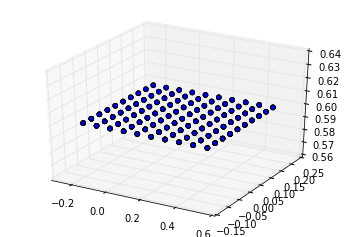

In [3]:
fig = libplot.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
pl = ax.scatter(X,Y,Z)

## Apprentissage du bras droit (prend quelques minutes)

In [4]:
xp.run()

KeyboardInterrupt: 

Lors de cet apprentissage, qui prend quelques minutes, Poppy va tenter différentes positions pour son bras; les positions du cube serviront de résultat expérimental : le cube a-t-il bougé ?

## Courbe d'apprentissage

On peut se donner une idée de ce que l'apprentissage a permis d'atteindre en termes d'erreur, et en termes de points atteints relativement aux points souhaités.

AssertionError: 

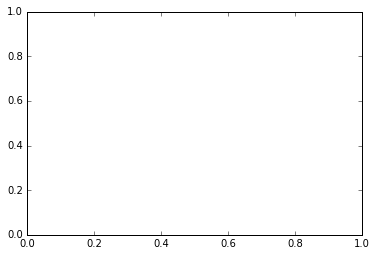

In [5]:
ax = libplot.subplot(111)
xp.log.plot_learning_curve(ax)

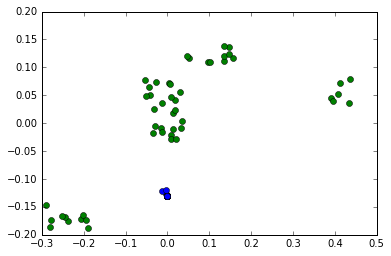

In [6]:
fig = libplot.figure()
ax = fig.add_subplot(1,1,1)
xp.log.scatter_plot(ax, (('sensori',  [0, 1]),), color='blue')
xp.log.scatter_plot(ax, (('choice',  [0, 1]),), color='green')


## Sauvergarde des résultats obtenus

On va sauvergarder les modèles d'intérêt et sensorimoteur que l'expérience nous a permis d'obtenir, dans un fichier.
Nous pourrons ainsi réutiliser ces modèles plus tard sans avoir à refaire l'apprentissage.

In [7]:
dumpTorsoResults()

# Usage des modèles d'intérêt et sensorimoteur appris

## Prependum : Chargement du modèle d'intérêt

Si vous n'avez pas effectué sur place l'apprentissage, vous pouvez charger les modèles sensorimoteur et d'intérêt depuis les fichiers où vous les avez sauvegardés:

In [ ]:
resetPoppy()
loadTorsoResults()

## Crash-test

On se propose maintenant de tester les modèles appris et de faire bouger le cube à Poppy.

<i>Il ne faut pas s'attendre à des miracles !</i>

L'expérience sera la suivante : on prendra un jeu de points au hasard dans un espace réputé atteignable (correspondant à peu de choses près à quatre fois la surface sur table du cube devant poppy), et l'on tentera de faire déplacer le cube pour chacun des points déterminés.

In [11]:
Npoints = 20
minX = -0.4
maxX = 0.4
minY = 0.1
maxY = 0.4
Xgoal = (maxX - minX) * numpy.random.random_sample(Npoints) + minX
Ygoal = (maxY - minY) * numpy.random.random_sample(Npoints) + minY
Zgoal = 0.5 # ok, the cube is always at the same height !
goals = [(Xgoal[i], Ygoal[i], 0.7) for i in range(Npoints)]

reachedXs = []
reachedYs = []

def goto(pos, duration=2.0):
    m_ag = sm_model.inverse_prediction(pos)
    m_env = env.compute_motor_command(m_ag)
    
    env.move_duration = duration
    env.compute_sensori_effect(m_env)

def runExperiment():
    global goals, poppy, reachedXs, reachedYs
    ioController = poppy._controllers[0].io
    for goal in goals:
        poppy.reset_simulation()
        goto(goal)
        reached = ioController.get_object_position('cube')
        reachedXs.append(reached[0])
        reachedYs.append(reached[1])

# Just do it !
runExperiment()

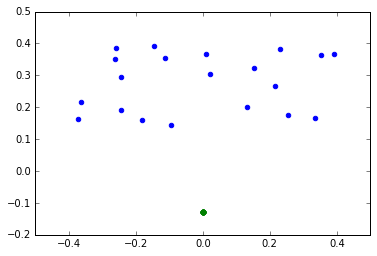

In [12]:
# And now, plot the results...

fig = libplot.figure()
ax = fig.add_subplot(111)

ax.scatter(Xgoal, Ygoal, color='blue')
ax.scatter(reachedXs, reachedYs, color='green')

# Observations et analyse

## Relativement à l'apprentissage

J'ai choisi d'utiliser le modèle sensorimoteur basé sur le plus proche voisin pondéré, ainsi que le modèle d'intérêt <i>discretized_progress</i>.

L'apprentissage est long et peu efficace : le seul senseur sur lequel nos modèles sensorimoteur et d'intérêt récupèrent des informations est le cube, ou plus précisément son senseur positionnel.

Sur un millier d'essais, Poppy a été toucher le cube une fois sur dix. Cependant, le grand nombre de points explorés en-dehors du cube permettent également de savoir que Poppy ne déplacera pas le cube s'il déplace son bras dans ces points : ce n'est pas parce que le cube n'a pas été touché que le robot n'a rien appris.

Deux stratégies d'apprentissage différentes peuvent être envisagées :
  * L'apprentissage par points aléatoirement choisis dans un espace uniformément distribué,
  * L'apprentissage favorisant les zones inconnues.

L'avantage de la première méthode sur la seconde est que pour un grand nombre d'essais, le cube sera potentiellement plus touché, et l'on aura donc la possibilité de le déplacer plus précisément lors de l'expérience.

A contrario, la seconde méthode nécessitera potentiellement moins d'essais que la première pour deviner la position du cube et être sûr d'aller le déplacer. 

Tout dépend du but de l'expérience : cherche-t-on seulement à <i>déplacer</i> le cube, ou cherche-t-on à le <i>déplacer vers un point précis</i> ?

Les courbes d'apprentissage ne sont hélas pas très parlantes, l'erreur commise est très importante car on effectue un goal babbling sur un objet que le robot n'est même pas sûr de toucher. Il est donc difficile de conclure sur l'efficacité d'une méthode à l'aide de ces courbes.

## Relativement à l'expérience post-apprentissage

Cette expérience semble assez peu concluante.

La librairie explauto n'a pas respecté la contrainte du nombre d'essais pour l'apprentissage: en 4 heures, l'apprentissage pour 50 essais n'était pas terminé, alors que plus de 4500 simulations ont eu lieu.

Le modèle sensorimoteur ainsi que le modèle d'intérêt produits donnent un unique point 